In [71]:

import pandas as pd
import gensim
from gensim import corpora
import json, glob
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# import spacy
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [72]:
df = pd.read_csv("twitter2.csv")

In [73]:
df['lemmatized_text']

0                                                    blush
1        term amenorrhea rather menopause similar diffe...
2        woman usually period experience menopause infe...
3        woman day feel like fire half time go early me...
4        like menopause mental illness taboo topic glad...
                               ...                        
44145    middle menopause journey alone cedar sinai dr ...
44146    woman menopause like sort disease mov efrom fe...
44147    woman want sometime catastrophic issue cause m...
44148         woman go menopause century rejoice live long
44149    get hot sweat gush blood total brain fog hideo...
Name: lemmatized_text, Length: 44150, dtype: object

In [74]:
df = df.dropna()

In [75]:
temp = [doc.split() for doc in df['lemmatized_text']]

In [76]:
tokens = [[word for word in sublist if len(word) > 1 and 'www' not in word and 'https' not in word] for sublist in temp]

In [77]:
bp = gensim.models.Phrases(tokens, min_count=5,threshold=50)
tp = gensim.models.Phrases(bp[tokens],threshold=10)

b_obj = gensim.models.phrases.Phraser(bp)
t_obj = gensim.models.phrases.Phraser(tp)

In [78]:
# data_bg = make_bigrams(tokens)
# data_tg = make_trigram(data_bg)

data_bg = list(b_obj[tokens])
data_tg = list(t_obj[data_bg])

In [79]:
from gensim.models import TfidfModel
dictionary = corpora.Dictionary(data_tg)
print(len(dictionary))

34587


In [80]:
corpus = [dictionary.doc2bow(doc) for doc in data_tg]

In [81]:
tfidf = TfidfModel(corpus, id2word = dictionary)
low_value = 0.03
words = []
words_missing_in_tfidf = []



In [82]:
for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(dictionary[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [98]:
#try 2,3,4,7

num_topics = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus, 
                                            num_topics=num_topics, 
                                            id2word=dictionary, 
                                            random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [19]:
# from tqdm import tqdm
# coherence_scores = []
# for num_topics in tqdm(range(2, 10)):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus, 
#                                                 num_topics=num_topics, 
#                                                 id2word=dictionary, 
#                                                 random_state=100,
#                                                update_every=1,
#                                                chunksize=100,
#                                                passes=10,
#                                                alpha="auto")
#     coherence_model = CoherenceModel(model=lda_model, 
#                                      texts=data_tg, 
#                                      dictionary=dictionary, 
#                                      coherence='c_v')
#     coherence_score = coherence_model.get_coherence()
#     coherence_scores.append(coherence_score)

In [20]:
# print("Coherence score",coherence_scores)

AttributeError: 'PreparedData' object has no attribute 'term_frequency'

In [99]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=50)
vis



/Users/aokiji/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.253836  0.302673       1        1  40.999516
2     -0.022273 -0.350212       2        1  17.606171
4     -0.348162 -0.095574       3        1  16.535478
0     -0.191605  0.282327       4        1  14.290870
3      0.308204 -0.139213       5        1  10.567965, topic_info=            Term          Freq         Total Category  logprob  loglift
26         woman  18535.000000  18535.000000  Default  50.0000  50.0000
33            go   7464.000000   7464.000000  Default  49.0000  49.0000
98       support   2940.000000   2940.000000  Default  48.0000  48.0000
852        leave   3155.000000   3155.000000  Default  47.0000  47.0000
213         work   3037.000000   3037.000000  Default  46.0000  46.0000
...          ...           ...           ...      ...      ...      ...
14069      pilot    221.575945    222.420132   Topic5  -5.5611   2.2435
10936    restful    246.352999    247.682351   Topic5  -5.4551   2.2420
8710      cruise    243.498240    244.875802   Topic5  -5.4668   2.2417
1728   hot_sweat    245.885879    247.599029   Topic5  -5.4570   2.2404
2776       awake    234.991693    237.179413   Topic5  -5.5023   2.2381

[311 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
593       4  0.998645   actually
369       3  0.997865        add
353       2  0.999194     affect
216       1  0.999598        age
540       4  0.999249      agree
...     ...       ...        ...
2918      2  0.999693  workplace
105       1  0.999592      would
780       3  0.996733        wow
1163      2  0.996725      wrong
121       1  0.999465       year

[276 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 4])

In [ ]:

imp_topic1 = ["woman","experience","age","suffer","peri","female","help","give","understand","man"] 
imp_topic2 = ["hrt","treatment","affect","condition","workplace","protect_characteristic","sex","someone","wife","learn"]
imp_topic3 = ["leave","work","health","workplace","dr","fiber","employer","struggle","perimenopause","career"]
imp_topic4 = ["badenoch","cause","right_wing","minister","political","government","agree","deal","state","disability"]
imp_topic5 = ["support","make","hope","problem","joy","insomnia","fun","hell","shame","sleep"]

# WordCloud

In [111]:
# To check words in a given topic

topic_id = 3

words = lda_model.show_topic(topic_id,topn=50)
for word,prob in words:
    print(word)

support
make
hope
hit
much
problem
joy
let
maybe
thank
light
hard
relate
since
everyone
heart
shame
discuss
sleep
process
bit
insomnia
place
fun
hell
treat
trust
menopauseawareness
listen
sort
bed
probably
middle
committee
haha
lucky
benefit
response
restful
hot_sweat
cruise
guess
awake
imagine
run
tweet
party
expect
pilot
kind


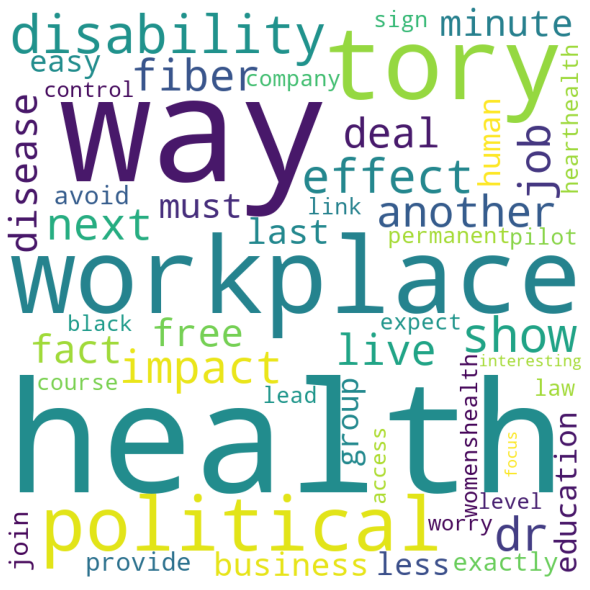

In [56]:
# To create word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary mapping words to their frequency
word_freq = {}
for word, prob in words:
    word_freq[word] = prob

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', 
                      min_font_size=10).generate_from_frequencies(word_freq)

# Display the generated image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


# sentiment analysis on the clusters

In [44]:
top_topics = lda_model.show_topics(num_topics=6)

In [45]:
sia = SentimentIntensityAnalyzer()
sentiments = []
for topic in top_topics:
    topic_id = topic[0]
    top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=20)]
    topic_words = ' '.join(top_words)
    topic_sentiment = sia.polarity_scores(topic_words)
    sentiments.append(topic_sentiment)

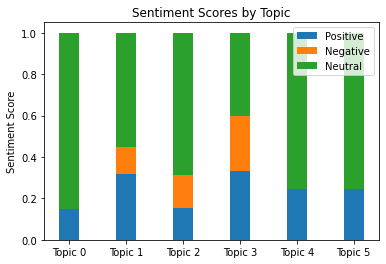

In [46]:
# Extract the sentiment scores for each topic
import numpy as np
import matplotlib.pyplot as plt
pos_scores = [sentiment['pos'] for sentiment in sentiments]
neg_scores = [sentiment['neg'] for sentiment in sentiments]
neu_scores = [sentiment['neu'] for sentiment in sentiments]
compound_scores = [sentiment['compound'] for sentiment in sentiments]

# Set up the plot
labels = [f"Topic {i}" for i in range(len(top_topics))]
x = np.arange(len(labels))
fig, ax = plt.subplots()

# Plot the stacked bars
ax.bar(x, pos_scores, 0.35, label='Positive')
ax.bar(x, neg_scores, 0.35, bottom=pos_scores, label='Negative')
ax.bar(x, neu_scores, 0.35, bottom=np.array(pos_scores)+np.array(neg_scores), label='Neutral')

# Add labels, title, and legend
ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment Scores by Topic')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()

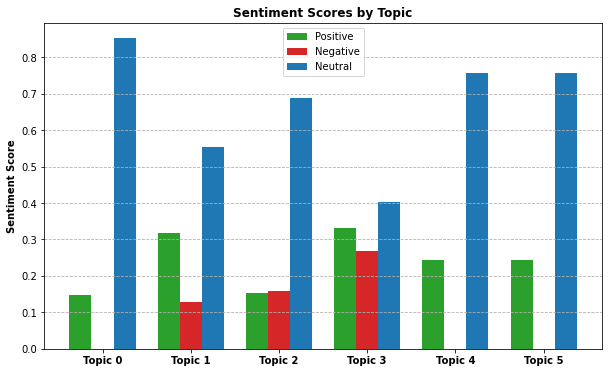

In [48]:
pos_scores = [sentiment['pos'] for sentiment in sentiments]
neg_scores = [sentiment['neg'] for sentiment in sentiments]
neu_scores = [sentiment['neu'] for sentiment in sentiments]

labels = [f"Topic {i}" for i in range(len(top_topics))]
x = np.arange(len(labels))
bar_width = 0.25
colors = ['#2ca02c', '#d62728', '#1f77b4']

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - bar_width, pos_scores, bar_width, label='Positive', color=colors[0])
ax.bar(x, neg_scores, bar_width, label='Negative', color=colors[1])
ax.bar(x + bar_width, neu_scores, bar_width, label='Neutral', color=colors[2])

ax.set_ylabel('Sentiment Score', weight='bold')
ax.set_title('Sentiment Scores by Topic', weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, weight='bold')
ax.legend()

ax.grid(axis='y', linestyle='--')

plt.show()

In [ ]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # lda_model is the trained LDA model
# num_topics = lda_model.num_topics

# # Get the topic-term matrix
# topic_term_matrix = lda_model.get_topics()

# # Calculate the pairwise cosine similarity between topics
# similarity_matrix = np.zeros((num_topics, num_topics))
# for i in range(num_topics):
#     for j in range(i+1, num_topics):
#         similarity = cosine_similarity(topic_term_matrix[i].reshape(1, -1), 
#                                         topic_term_matrix[j].reshape(1, -1))[0][0]
#         similarity_matrix[i][j] = similarity
#         similarity_matrix[j][i] = similarity

# # Visualize the similarity matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.heatmap(similarity_matrix, annot=True, cmap='Blues')
# plt.title('Topic Similarity Matrix')
# plt.xlabel('Topic ID')
# plt.ylabel('Topic ID')
# plt.show()


In [ ]:

imp_topic1 = ["woman","experience","age","suffer","peri","female","help","give","understand","man"] 
imp_topic2 = ["hrt","treatment","affect","condition","workplace","protect_characteristic","sex","someone","wife","learn"]
imp_topic3 = [""]